# DSP. Assignment 3

**Students**: Anna Boronina, Pavel Tishkin

**Emails**: a.boronina@innopolis.university, p.tishkin@innopolis.university

**Group**: BS18-DS-02


### Task 1
#### Part 1

To start off, that's where we had our audio recorded:

<div align="center">
<img src=https://drive.google.com/uc?export=view&id=1QcaYU2_Jd4aZkHHsUlBmgca7jUVF3bK6 width="300">
</div>



In [1]:
from IPython.display import Audio

original = './clap.ogg'
print('warning: for some reason jupyter notebook doesn\'t want to play such short recording but it\'s ok in colab')
Audio(filename=original)

We have done some preprocessing using ffmpeg - cut the first 0.05 second so that the clup is at the very beginning

What we have got after is below. It will be our kernel.

In [2]:
preprocessed = './clap_cut_ffmpeg.ogg'
print('warning: for some reason jupyter notebook doesn\'t want to play such short recording but it\'s ok in colab')
Audio(filename=preprocessed)

Let's normalize the recording and plot it. We can see that the signal is decaying: the closer to the end, the smaller signal's amplitude.

shape: (22050,), max value after normalization: 1.0


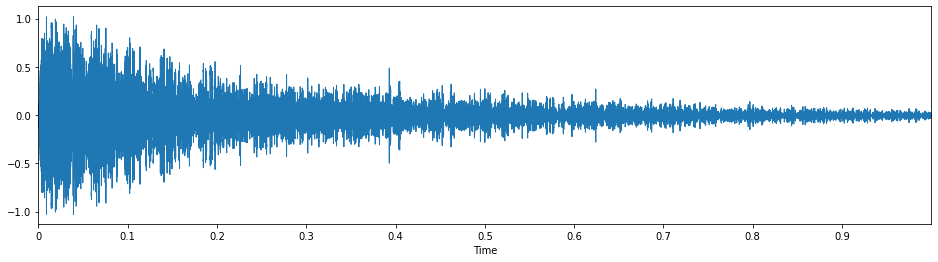

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import warnings
warnings.filterwarnings('ignore')

x, sr = librosa.load(preprocessed)
x = x / np.max(x)

print(f'shape: {x.shape}, max value after normalization: {max(x)}')

plt.figure(figsize=(16, 4))
librosa.display.waveplot(x, sr=sr)

#### Part 2

Let's convolve our signal with Dirac delta function $\delta$:

<div align="center">
<img src=https://drive.google.com/uc?export=view&id=1vFDe8I2Ny-t-EMpLT42FU9-rFOZtzy3L width="150">
</div>

What we have done to optimize the process of convolution:
1. used njit from numba. njit compiles and runs in nopython mode, which is the best approach
2. used numpy arrays and numpy functions, which numba loves to optimize

In [4]:
from scipy.signal import unit_impulse
from numba import njit
from math import sqrt
import numpy as np


def fft_convolve(x, h):
    size = len(x) + len(h) - 1
    fft_x = np.fft.fft(x, size)
    fft_h = np.fft.fft(h, size)
    assert len(fft_x) == len(fft_h), 'Lengths of fft_x and fft_h must be the same'

    ifft_result = np.fft.ifft(fft_x * fft_h)
    return ifft_result


@njit
def get_elem(x, i):
    return 0 if i < 0 or i >= len(x) else x[i]


@njit(parallel=True)
def reg_convolve(x, h):
    size = len(x) + len(h) - 1
    window = len(x)
    result = []
    for n in range(size):
        gen = np.sum(np.array([get_elem(x, k) * get_elem(h, n-k) for k in range(window)]))
        result.append(gen)
    return np.array(result)


def convolve(x, h, fft_based=False):
    """
    x:         signal 1 (typically recording)
    h:         signal 2 (typically filter)
    fft_based: convolve using FFT or not (False by default)
    """
    if fft_based:
        return fft_convolve(x, h)
    else:
        return reg_convolve(x, h)

Let's time the regular convolution approach:

In [5]:
from numpy.random import randint
def get_signal(size):
    return randint(low=-100, high=100, size=size)

temp_x = get_signal(4000)
temp_h = get_signal(100)
print(f'x signal: {temp_x.shape}, h signal: {temp_h.shape}')

x signal: (4000,), h signal: (100,)


To make sure it's correct, let's use `np.convolve` to compare the results:

In [6]:
from scipy.signal import fftconvolve
warnings.filterwarnings('ignore')

conv_regular = convolve(temp_x, temp_h)
np_conv_regular = np.convolve(temp_x, temp_h)
print(f'our regular: {conv_regular}')
print(f'np.convolve: {np_conv_regular}\n')
print(f'our regular size: {len(conv_regular)}, np.convolve size: {len(np_conv_regular)}\n\n')

conv_fft = convolve(temp_x, temp_h, fft_based=True)
scipy_conv_fft = fftconvolve(temp_x, temp_h)
print(f'our FFT:                  {conv_fft}')
print(f'scipy.signal.fftconvolve: {scipy_conv_fft}\n')
print(f'our FFT size: {len(conv_fft)}, scipy.signal.fftconvolve: {len(scipy_conv_fft)}')

our regular: [ 4836  1256 -8376 ...  3799 -4861  4672]
np.convolve: [ 4836  1256 -8376 ...  3799 -4861  4672]

our regular size: 4099, np.convolve size: 4099


our FFT:                  [ 4836.+6.82121026e-12j  1256.+1.96340721e-11j -8376.-4.80682161e-12j ...
  3799.+8.61533067e-12j -4861.-3.97015754e-12j  4672.+1.05080389e-11j]
scipy.signal.fftconvolve: [ 4836.  1256. -8376. ...  3799. -4861.  4672.]

our FFT size: 4099, scipy.signal.fftconvolve: 4099


#### Part 3

Let's try to apply our filter to some recordings, but we need to load the recordings themselves first:

In [7]:
sounds_dir = './DSP_2020_A3_DATA'
drums = 'drums.wav'
music_20s = 'music_20s_8000.wav'
speech = 'speech.wav'
violin = 'violin.wav'
voice = 'voice.wav'

def path(rec):
    return f'{sounds_dir}/{rec}'

print('drumsssss: ')
Audio(filename=path(drums))

drumsssss: 


In [8]:
x_drums, sr_drums = librosa.load(path(drums))
x_drums = x_drums[:10 * sr_drums]

x_speech, sr_speech = librosa.load(path(speech))
x_speech = x_speech[:10 * sr_speech]

x_violin, sr_violin = librosa.load(path(violin))
x_violin = x_violin[:10 * sr_violin]

x_voice, sr_voice = librosa.load(path(voice))
x_voice = x_voice[:10 * sr_voice]

audios = {
    'speech': x_speech,
    'drums': x_drums,
    'violin': x_violin,
    'voice': x_voice,
}

In [9]:
sample_rates = {
    'drums': 48000,
    'speech': 44100,
    'violin': 96000,
    'voice': 48000
}

In [10]:
conv_results = {
    'drums': convolve(x_drums, x, fft_based=True),
    'speech': convolve(x_speech, x, fft_based=True),
    'violin': convolve(x_violin, x, fft_based=True),
    'voice': convolve(x_voice, x)
}

You can compare any recording in its before state and after.

In [11]:
sound1 = 'voice'
Audio(audios[sound1], rate=sample_rates[sound1]/2)

In [12]:
Audio(conv_results[sound1], rate=sample_rates[sound1]/2)

In [13]:
sound2 = 'speech'
Audio(audios[sound2], rate=sample_rates[sound2]/2)

In [14]:
Audio(conv_results[sound2], rate=sample_rates[sound2]/2)

#### Part 4

First of all, let us start with the definitions of the Linear Convolution and Circular convolution
* **Linear Convolution:** The linear convolution of finite signals is defined by extending the
finite signals as two-side infinite sequences that are zeros outside
support of the signals. If signal has finite support ($[0; m]$ in our case):
$$(x \star y)_n = \sum_{k \in \mathbf{Z}}x_ky_{n-k} = \sum_{k \in [0;m-1]}x_ky_{n-k}$$
* **Circular Convolution:** Circular convolution between two finite sequences $x$ and $y$ of some fixed length $m>0$ is the following sequence of the same length $m$:
$$(x^{(\star)}y)_n = \sum_{k=0}^{m-1}x_ky_{(n-k)mod\ m}$$

**Theorem:**  Linear and circular convolutions between finite sequences $x$ and $y$ are equivalent when the period of the circular convolution $m$ satisfies the following inequality $m \ge m_x+m_y - 1$ where $m_x$ and $m_y$ are size of $x$ and $y$ supports respectively.  
**Proof:** Let us take $$x = \begin{pmatrix} \mathbf{x_0} & x_1 & ... & x_{m_x-1} \end{pmatrix}$$ $$y = \begin{pmatrix} \mathbf{y_0} & y_1 & ... & y_{m_y-1} \end{pmatrix}$$ and arbitrary $m \ge m_x + m_y-1$.  
Firstly, we need to extend signals to the length of support $m$:
$$x = \begin{pmatrix} \mathbf{x_0} & x_1 & ... & x_{m_x-1} & 0 & ... & x_{m-1}=0 \end{pmatrix}$$
$$y = \begin{pmatrix} \mathbf{y_0} & y_1 & ... & y_{m_y-1} & 0 & ... & y_{m-1} = 0 \end{pmatrix}$$
Let us calculate Linear and Circular convolutions of these two sequences:
* **Linear Convolution:** Let us extend the signals to infinite signals:
$$x = \begin{pmatrix} ... & 0 & \mathbf{x_0} & x_1 & ... & x_{m_x-1} & 0 & ... & x_{m-1}=0 & ... \end{pmatrix}$$
$$y = \begin{pmatrix} ... & 0 & \mathbf{y_0} & y_1 & ... & y_{m_y-1} & 0 & ... & y_{m-1} = 0 & ... \end{pmatrix}$$
Then, we will compute convolution using the fact these signals have finite support $m$:
$$(x \star y)_n = \sum_{k \in \mathbf{Z}} x_ky_{n-k} = \sum_{k \in [0;m-1]} x_ky_{n-k} = (x_0y_n + x_1y_{n-1} + ... + x_ny_{0}) + (x_{n+1}y_{-1} + x_{n+2}y_{-2} + ... + x_{m_x-1}y_{n-(m_x-1)})$$
Let us analyze the second brackets. The multiplications in them include the elements $y_k=0, k\le-1$, since we extended $y$ with zeros. Therefore, the products will be equal to $0$ and, as a result, the whole sum in brackets will be $0$:
$$(x_0y_n + x_1y_{n-1} + ... + x_ny_{0}) + (x_{n+1}y{-1} + x_{n+2}y_{-2} + ... + x_{m_x-1}y_{n-(m_x)-1}) = (x_0y_n + x_1y_{n-1} + ... + x_ny_{0})$$
* **Circular convolution:**
$$(x^{(\star)}y)_n = \sum_{k=0}^{m-1}x_ky_{(n-k)mod\ m} = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{(-1)mod\ m} + x_{n+2}y_{(-2)mod\ m} + ... + x_{m_x}y_{(n-(m_x-1))mod\ m}) = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{m-1} + x_{n+2}y_{m-2} + ... + x_{m_x}y_{(m + n - (m_x-1))})$$ 
Let us analyze the second brackets. The elements, taken from signal $y_k$, $k\in [m + n - (m_x-1); m-1]$. Since we extended $y$ by zeros, the only non-zero values of $y$ have indeces $[0; m_y-1]$. The least index from the one we are taking is: 
$$m + n - (m_x-1) \ge m_x+m_y-1 +n - m_x +1 = m_y + n > m_y$$
Therefore, $y_{m + n - (m_x-1)} = 0$ and all the consecutive elements. All of the products in the brackets equal to $0$ and, therefore, the whole sum is $0$:
$$ (x_0y_n + x_1y_{n-1} + ... + x_ny_0) + (x_{n+1}y_{m-1} + x_{n+2}y_{m-2} + ... + x_{m_x}y_{(m + n - (m_x-1))}) = (x_0y_n + x_1y_{n-1} + ... + x_ny_0)$$ 

As a result we got:
$$ (x \star y)_n = (x_0y_n + x_1y_{n-1} + ... + x_ny_0) = (x^{(\star)}y)_n \ \blacksquare$$

#### Part 5



We need to compare the complexities of regular approach and FFT-based approach that we've implemented. Use code from task 1 part 2 as a reference.

Function `convolve()` takes two signals: `x` and `h`. For further calculations, let's say that $N$ is the length of `x` and $M$ is the length of `h`.

**Regular approach**

We use signal `x` as a window because we assume that $N > M$. And it probably should be the case because we pass `x` as some recording and `h` as some filter to be applied and a filter is normally shorter than a recording. 

So, we can see the convolution as matrix multiplication: $$C = LR$$ where $L$'s size is $(N+M-1) \text{x}N$ and $R$'s size is $N \text{x} 1$. The resulting vector $C$ has size $(N+M-1) \text{x}1$.

If we do it vise versa then our matrix $L$ will have a lot of redundant zeros which is bad for performance.

To calculate the time complexity, we say that we walk over `x` of length $N$ $M+N-1$ times. 

**Regular approach time complexity: $\boldsymbol{O(N(N+M))}$.**

**FFT-based approach**

In FFT-based approach we do the following: 
1. compute FFT of `x` and make it of size $N+M-1$ $\rightarrow$ $\boldsymbol{O(N log N)}$
2. compute FFT of `h` and make it of size $N+M$ $\rightarrow$ $\boldsymbol{O(M log M)}$
3. do element-wise multiplication of `x` and `h` in frequency domain $\rightarrow$ $\boldsymbol{O(N+M-1)}$
4. perform IFFT on the result of step 3 $\rightarrow$ $\boldsymbol{O((N+M)log(N+M))}$

Let's take the sum of complexities above and omit constants:
$O(NlogN + MlogM + (N+M) + (N+M)log(N+M))$

$= O(NlogN + MlogM + (N+M)log(N+M) + 1)$

$= O(NlogN + MlogM + (N+M)log(N+M))$

$= O(NlogN + MlogM + Nlog(N+M) + Mlog(N+M)$

$= O(N(logN + log(N+M) + M(logM + log(N+M))$

$= O(N(log(N(N+M)) + M(log(M(N+M)))$

**FFT-based approach time complexity: $\boldsymbol{O(N(log(N(N+M))) + M(log(M(N+M))))}$.**

Generally it's recommended to use FFT-based approach for convolution, as it's faster. This recommendation assumes that we work with a lot of samples. Let's see if there are any $N$ and $M$ for which regular approach is faster.

$$N(N+M) < N(log(N(N+M)) + M(log(M(N+M)) \text{ when } N > M$$

$$\frac{N}{M} < \frac{log(M(N+M)}{N+M-log(N(N+M))}$$

If we say that $N = kM$ then regular approach is better than FFT-based approach when $\frac{log(M(N+M)}{N+M-log(N(N+M))} > k$.

For example, for $N = 100000 \text{ and } M=1000$:



In [15]:
from math import log2
from pandas import DataFrame

def check_if_holds(N, M):
    k = N / M
    right_part = log2(M * (N + M)) / (N + M - log2(N * (N + M)))
    return k, right_part, k < right_part

cases = {
    0: (2, 2),
    1: (2, 4),
    2: (10, 1000),
    3: (4, 2),
    4: (5, 2),
    5: (10, 10),
    6: (100, 100),
    7: (1000, 1000),
    8: (100000, 100000), 
    9: (1000000, 20000)
}

df = DataFrame(columns=['N', 'M', 'k < fraction', 'holds'])
for (N, M) in cases.values():
    k, right_part, holds = check_if_holds(N, M)
    df = df.append({'N': N, 'M': M, 'k < fraction': f'{k} < {right_part}', 'holds': holds}, ignore_index=True)

df

,N,M,k < fraction,holds
0,2,2,1.0 < 3.0,True
1,2,4,0.5 < 1.898505717650461,True
2,10,1000,0.01 < 0.020012004856600665,True
3,4,2,2.0 < 2.5334752630571185,True
4,5,2,2.5 < 2.035238337249648,False
5,10,10,1.0 < 0.6186279722197052,False
6,100,100,1.0 < 0.07693466362737375,False
7,1000,1000,1.0 < 0.010576475394634367,False
8,100000,100000,1.0 < 0.00017112568373361435,False
9,1000000,20000,50.0 < 3.357763683362441e-05,False


From the table above we can observe that the regular approach is better in the following cases:
1. When both signals are extremely short are very small
2. When recording is extremely short and filter is very long


Look at cases 5-8 where $N = M$. The larger they are, the longer the distance between $k = 1.0$ and $fraction = \frac{log(M(N+M)}{N+M-log(N(N+M))}$. It means that FFT-based approach is definitely better for large $N$ and $M$. Nevertheles,, regular approach is not very bad.


And, finally, the last case which should be typical for convolution: some relatively long recording and kind of short filter. In that case we can see how far $k$ is from $fraction$.

That's all the analysis we can do regarding assymtotic complexity of two convolution approaches. The simple result is that FFT-based approach is better in all typical cases. Regular approach is just not so bad when $N$ and $M$ are close.
 
At last, let's run our functions to check the time. This experiment is not very clear, since we use a particul language and optimizations here and there. Anyway, let's run it.

In [16]:
def get_signal(size):
    return randint(low=-100, high=100, size=size)

test_pairs = []
for (N, M) in cases.values():
    test_pairs.append((get_signal(N), get_signal(M)))

In [17]:
print('for each pair of x and h you\'ll see two rows: regular approach time and FFT-based approach time')

for (x, h) in test_pairs[:-1]:
    print(f'x: {x.shape}, h: {h.shape}')
    %timeit -o convolve(x, h)
    %timeit -o convolve(x, h, fft_based=True)
    print()

for each pair of x and h you'll see two rows: regular approach time and FFT-based approach time
x: (2,), h: (2,)
The slowest run took 2911.73 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 3.94 µs per loop
The slowest run took 112.33 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.8 µs per loop

x: (2,), h: (4,)
The slowest run took 26.17 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 3.74 µs per loop
The slowest run took 7.27 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.3 µs per loop

x: (10,), h: (1000,)
The slowest run took 6.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.7 µs per loop
1000 loops, best of 5: 288 µs per loop

x

## Task 2

### Part 1

The equation of the Canonical form is the following:
$$y_k = \sum_{m=0}^M b_mf_{k-m}$$
$$f_l = x_l + \sum_{n=1}^N a_nf_{l-n}$$

### Part 2

In [18]:
@njit(nopython=True)
def IIR(signal, a, b):
    l_a = a.shape[0]
    l_b = b.shape[0]
    
    res = np.zeros(signal.shape[0])
    for i in range(signal.shape[0]):
        for j in range(l_b):
            if i-j >= 0:
                res[i]+=b[j]*signal[i-j]
        for j in range(l_a):
            if i-(j+1) >= 0:
                res[i]+=a[j]*res[i-(j+1)]
    return res

We also tried to implement the Canonical form of IIR filter. However, it appears standart filter is more memory efficient for us.

In [19]:
@njit(nopython=True)
def IIR_canon(signal, a, b):
    l_a = a.shape[0]
    l_b = b.shape[0]
    
    f = np.zeros(signal.shape[0])
    y = np.zeros(signal.shape[0])
    for i in range(signal.shape[0]):
        f[i] = signal[i]
        for j in range(l_a):
            if i-(j+1) >= 0:
                f[i]+=a[j]*f[i-(j+1)]
        for j in range(l_b):
            if i-j >= 0:
                y[i]+=b[j]*f[i-j]
    return y

### Part 3

In [20]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones

a_low = np.r_[1.9733442497812987,
 -0.9736948719763]# coefficients for a_1 and a_2
b_low = np.r_[0.00008765554875401547,
 0.00017531109750803094,
 0.00008765554875401547] # coefficients for b_0, b_1 and b_2
# Highpass, starts passing frequencies after 3kHz
a_high = np.r_[-0.3769782747249014,
 -0.19680764477614976] # coefficients for a_1 and a_2
b_high = np.r_[0.40495734254626874,
 -0.8099146850925375,
 0.4049573425462687] # coefficients for b_0, b_1 and b_2

### Part 4

In [29]:
from scipy.io.wavfile import read
# Reading signal
rate, signal = read(path(music_20s))
print('Original recording:')
Audio(signal, rate=rate)

Original recording:


In [22]:
# Lowpass filter
low = IIR(signal, a_low, b_low)
# Highpass filter
high = IIR(signal, a_high, b_high)

In [26]:
# Listening to the result (Lowpass filter)
print('Lowpass Filter:')
Audio(low, rate=rate)

Lowpass Filter:


In [27]:
# Listening to the result (Highpass filter)
print('Highpass Filter:')
Audio(high, rate=rate)

Highpass Filter:


### Part 5

In [32]:
# https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html
from scipy.fft import fft, fftfreq

# FFT of original signal
# Number of sample points
N = signal.shape[0]

# sample spacing
T = 1.0 / rate
signal_yf = fft(signal)
signal_xf = fftfreq(N, T)

# FFT of lowpass filter
low_yf = fft(low)
low_xf = fftfreq(N, T)[0:N//2]

# FFT of highpass filter
high_yf = fft(high)
high_xf = fftfreq(N, T)[0:N//2]

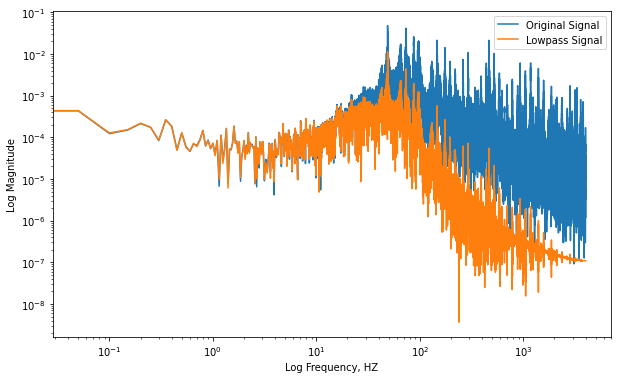

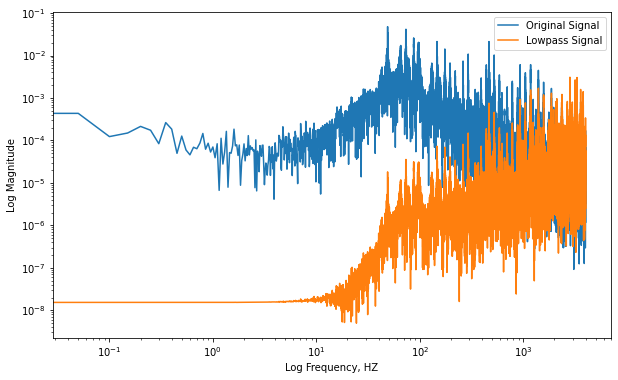

In [35]:
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

def plot_filtered(xf, yf, label1, label2):
    plt.figure(figsize=(10, 6))
    plt.plot(signal_xf[0:N//2], 2.0/N * np.abs(signal_yf[0:N//2]), label = label1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label = label2)
    plt.legend()
    plt.xlabel('Log Frequency, HZ')
    plt.ylabel('Log Magnitude')
    plt.yscale('log')
    plt.xscale('log')


# Plotting Low-Pass:
plot_filtered(low_xf, low_yf, 'Original Signal', 'Lowpass Signal')
# Plotting High-Pass
plot_filtered(high_xf, high_yf, 'Original Signal', 'Lowpass Signal')